### Constant loading and mutant loading for PMMA


The next step of our internship is to simulate the nonmonotonic aging and memory for viscoelastic rough surface contact. Dillavou(2018)[1] provides experimental data for PMMA(poly methylmethacrylate) rough contact, and we mainly focus on the real area of contact between the blocks $A_R$:

![](figures/contact_area_VS_time_Dillavou_2018.png)

Glassy dynamics in the real area of contact: $A_R$ and $F_N$ versus time for a typical two-step protocol with $F_1=100 \mathrm{~N}$, $T_W=1000 \mathrm{~s}, F_2=25 \mathrm{~N}$.

About our numerical implementation, we basically apply Generalized Maxwell model, which is a widely-used viscoelastic model. The generalized Maxwell model has several units of the Maxwell elements connected in parallel (also called the Weichert model if a free spring is included). Wayne(2011)[2] presents a 3-D semi-analytical contact model for viscoelastic materials, utilizing the Conjugate Gradient method and Fast Fourier Transform to efficiently simulate contact responses under complex loading conditions. 

In Wayne(2011)[2], the relaxation modulus function, $\psi_r(t)$, is defined to be the ratio of the stress history over the constant strain:

$$
\psi_r(t)=\frac{\sigma(t)}{\varepsilon_0}
$$

Likewise, the creep compliance function $\varphi_c(t)=\frac{\varepsilon(t)}{\sigma_0}$ is used to represent the strain creep behavior of a viscoelastic material under a constant stress.

And with generalized Maxwell model, the effective relaxation modulus can be written as:

$$
\psi_r(t)=\left[g_0+\sum_{i=1}^n g_i \exp \left(-t / \tau_i\right)\right] H(t)
$$

Here, $\tau_i$ is the relaxation time of one elemental model, which equals the ratio of the dashpot viscosity $\eta_i$ to the spring stiffness $g_i$, and $H(t)$ the Heaviside step function.

The typical value of the Poisson ratio of PMMA is about 0.35~0.4; in this study, we keep it simple with incompressible behaviour, $\nu=0.5$.

Kumar(2004)[3] have conducted a standard relaxation test under uniaxial compression to characterize the viscoelastic response of PMMA. The measured relaxation modulus curve up to 1000 sec is shown:



![](figures/Measured_relaxation_modulus_function_of_PMMA.png)



A two-term Prony series is utilized here to fit the relaxation curve of PMMA (curve fitting R-squared=0.99957):

$$
\begin{aligned}
\psi_r(t)= & 1429.71+184.62 \exp \left(-\frac{t}{8.93}\right) \\
& +191.06 \exp \left(-\frac{t}{117.96}\right), \quad(\mathrm{MPa})
\end{aligned}
$$

Here we will use tamaas viscoelastic function to reproduce this simulation.

### For surface, we can set rms to control the random surface generation(https://tamaas.readthedocs.io/en/latest/api_reference.html#tamaas._tamaas.Statistics2D.contact)

### Q1: Sample surface roughness ranges from the original extruded PMMA (11 nm rms) to surfaces lapped with 220 grit polishing paper (1.8 μmrms)? and what about surface.size?
A1: We can compute rms[staticcomputeRMSHeights(arg0: GridWrap<T, dim>)→ float] and "normalize" it

We should apply surface with mm scale.

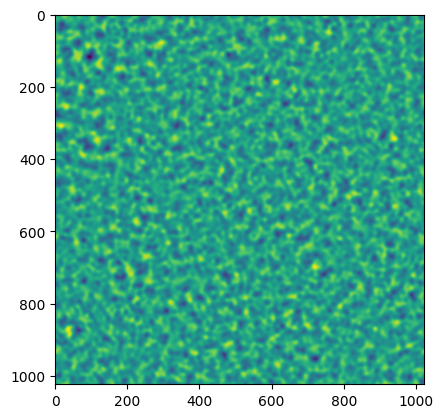

In [18]:
import tamaas as tm
import matplotlib.pyplot as plt
import numpy as np

from tamaas.utils import publications

# Initialize threads and fftw
tm.set_log_level(tm.LogLevel.info)  # Show progression of solver

# Surface size
n = 1024

# Surface generator
sg = tm.SurfaceGeneratorFilter2D([n, n])
sg.random_seed = 1

# Spectrum
sg.spectrum = tm.Isopowerlaw2D()

# Parameters
sg.spectrum.q0 = 16
sg.spectrum.q1 = 16
sg.spectrum.q2 = 64
sg.spectrum.hurst = 0.8

# Generating surface
surface = sg.buildSurface()
surface /= tm.Statistics2D.computeSpectralRMSSlope(surface)

plt.imshow(surface)


For two Maxwell branches in generalized Maxwell model, we have their shear moduli and relaxation time(characteristic time):

```cpp
shear_modulus = [184.62, 191.06]
characteristic_time = [8.93, 117.96]
```

### Q2: how can we set $G_\infty$ in tamaas?

A2: In Wayne(2011)[2], we have $g_0$ as shear modulus for elastic branch of generalized Maxwell model, and in numerical implementation we use `model.getShearModulus()` to get shear modulus for this branch, such that we times a factor for material elastic property.

In [31]:
%matplotlib inline

In [46]:
# Creating model
model = tm.ModelFactory.createModel(tm.model_type.basic_2d, [1., 1.], [n, n])

# Setting parameters
model.nu = 0.5
#model.E = 1429.71*2*(1+model.nu) #times a factor for material elastic property
model.E = 2 / (1 - model.nu)
model.E_star
#E_star = model.E / (1 - model.nu**2)

Ginf = 1429.71
shear_modulus = np.array([184.62, 191.06]) / Ginf
#characteristic_time = [8.93, 117.96]
characteristic_time = [20, 100]

#shear_modulus = [1, 1]
#characteristic_time = [10, 100]

In [47]:
t0 = 0
t1 = 100
time_steps = 25
dt = (t1 - t0)/time_steps

### Q3: getTraction to get contact area for rough surface??

In [48]:
#Solver
solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)

# Solve for target pressure
#p_target1 = 100#avarge pressure
p_target1 = 0.001 * model.E_star
p_target2 = p_target1 / 4

tm.Statistics2D.contact(model.traction)
model.traction[:] = 0
model.displacement[:] = 0

# Solve for target pressure
contact_area = []
for i in range(time_steps):
    if i < time_steps // 2:
        solver.solve(p_target1)
    else:
        solver.solve(p_target2)
    contact_area.append(tm.Statistics2D.contact(model.traction))

 Iter          Cost_f           Error
    0   -8.521863e-05    2.721704e+00
   68   -2.064466e-04    5.482527e-13
 Iter          Cost_f           Error
    0   -1.462423e-04    6.681359e-03
   47   -2.059410e-04    8.557617e-13
 Iter          Cost_f           Error
    0   -1.458799e-04    5.833774e-03
   48   -2.055028e-04    6.324438e-13
 Iter          Cost_f           Error
    0   -1.455646e-04    5.045771e-03
   48   -2.051213e-04    7.707402e-13
 Iter          Cost_f           Error
    0   -1.452890e-04    4.383334e-03
   47   -2.047876e-04    6.585561e-13
 Iter          Cost_f           Error
    0   -1.450469e-04    3.825247e-03
   46   -2.044943e-04    9.666303e-13
 Iter          Cost_f           Error
    0   -1.448334e-04    3.415765e-03
   46   -2.042357e-04    8.645999e-13
 Iter          Cost_f           Error
    0   -1.446442e-04    3.008962e-03
   46   -2.040064e-04    8.786013e-13
 Iter          Cost_f           Error
    0   -1.444758e-04    2.663804e-03
   46   -2.0

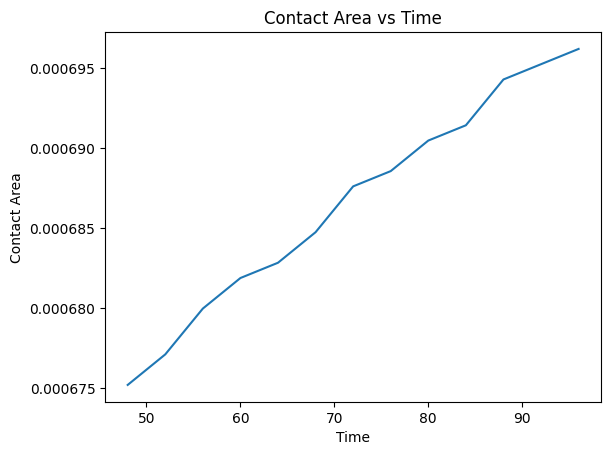

In [49]:
plt.plot(np.arange(time_steps)[time_steps // 2:] * dt, contact_area[time_steps // 2:])
plt.xlabel('Time')
plt.ylabel('Contact Area')
plt.title('Contact Area vs Time')
plt.show()

[1] Dillavou, Sam, and Shmuel M. Rubinstein. ‘Nonmonotonic Aging and Memory in a Frictional Interface’. Physical Review Letters 120, no. 22 (1 June 2018): 224101. https://doi.org/10.1103/PhysRevLett.120.224101.

[2] Wayne Chen, W., Q. Jane Wang, Z. Huan, and X. Luo. ‘Semi-Analytical Viscoelastic Contact Modeling of Polymer-Based Materials’. Journal of Tribology 133, no. 4 (1 October 2011): 041404. https://doi.org/10.1115/1.4004928.

[3] Kumar, M. V. R., and Narasimhan, R., 2004, “Analysis of Spherical Indentation of Linear Viscoelastic Materials,” Curr. Sci., 87, pp. 1088–1095.
